In [25]:
import boto3
import io
import constants
import pickle
import matplotlib.pyplot as plt
import torch


In [12]:
def get_loss_from_run(run_name):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/loss.pickle")
    byte_stream = response["Body"].read()
    data = pickle.load(io.BytesIO(byte_stream))
    return data


In [31]:
def get_epoch_images(run_name, epoch):
    s3 = boto3.client("s3")
    data = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/data.pt")
    data = pickle.loads(data["Body"].read())

    targets = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/targets.pt")
    targets = pickle.loads(targets["Body"].read())

    predictions = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/predictions.pt")
    predictions = pickle.loads(predictions["Body"].read())
    return {
        "data" : data,
        "targets": targets,
        "predictions": predictions
    }

In [112]:
epoch_data = get_epoch_images("03-26_02:26:55", 0)


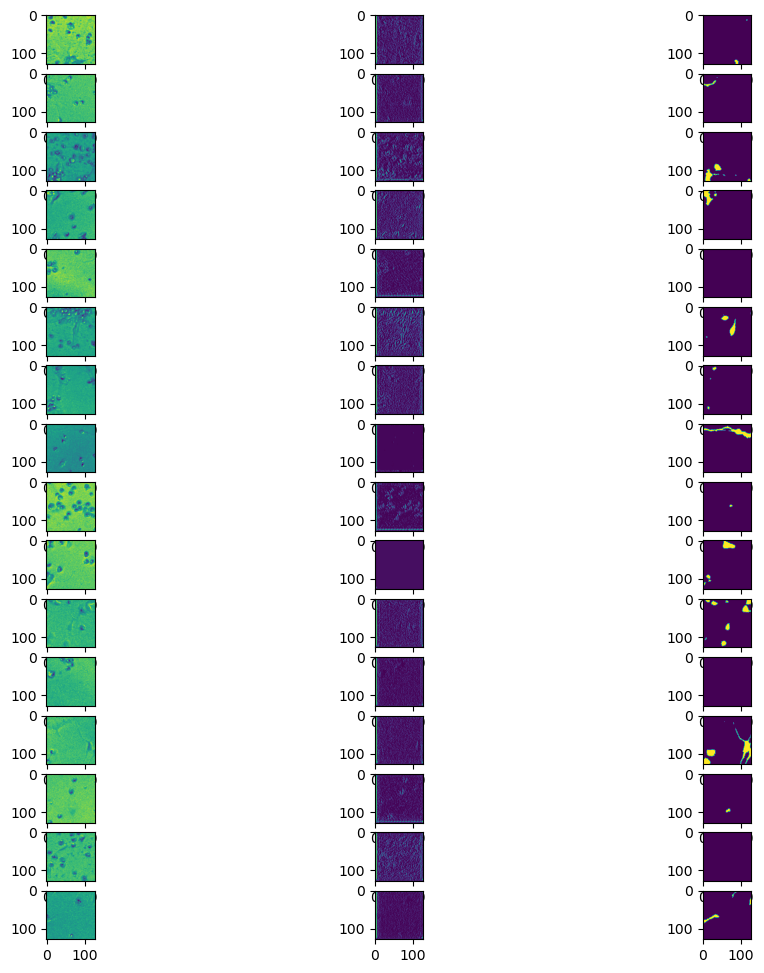

In [113]:
fig, ax = plt.subplots(nrows = epoch_data["data"].shape[0], ncols=3, figsize = (12, 12))
for i in range(epoch_data["data"].shape[0]):
    data = epoch_data["data"][i].squeeze()
    pred = epoch_data["predictions"][i].squeeze().detach().to(torch.float32).numpy()
    target = epoch_data["targets"][i].squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

In [110]:
loss_data = get_loss_from_run("03-26_02:26:55")

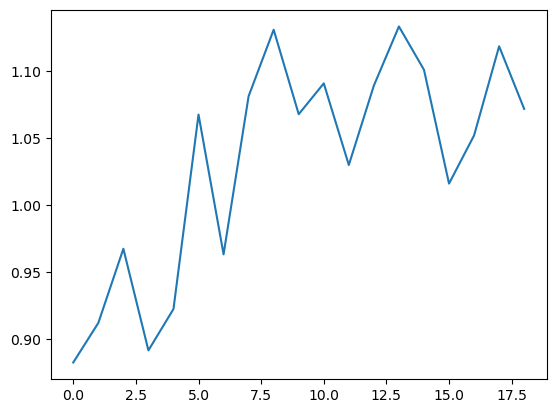

In [111]:
plt.plot(loss_data)

In [98]:
predictions = epoch_data["predictions"]
targets = epoch_data["targets"]
targets_mask = (targets > 0).float()
sig_preds = torch.sigmoid(predictions) # going to have to remove when running on updated model
pred_mask = (sig_preds > 0.5).float()

dice = (2 * (targets_mask * pred_mask).sum()) / (pred_mask.sum() + targets_mask.sum())

In [99]:
dice

tensor(0.0466)

In [75]:
num_correct = (pred_mask == targets).sum()

In [76]:
num_correct

tensor(36784)

In [81]:
num_pixels = torch.numel(targets)


65536

In [91]:
accuracy = num_correct / num_pixels

In [92]:
accuracy

tensor(0.5613)

In [115]:
torch.backends.mps.is_built()

True

In [116]:
import math
dtype = torch.float
device = torch.device("mps")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 487.4205322265625
199 343.5338439941406
299 243.0570068359375
399 172.8428497314453
499 123.74331665039062
599 89.38652801513672
699 65.33074188232422
799 48.477516174316406
899 36.66364288330078
999 28.37781524658203
1099 22.563425064086914
1199 18.481346130371094
1299 15.614131927490234
1399 13.599334716796875
1499 12.182951927185059
1599 11.186859130859375
1699 10.486074447631836
1799 9.992877006530762
1899 9.645658493041992
1999 9.40113353729248
Result: y = 0.024844706058502197 + 0.8623283505439758 x + -0.004286123439669609 x^2 + -0.0941251590847969 x^3
